# Sentiment analysis on the Amazon review dataset, using bagging and LinearSVC

We begin by importing the various libraries and functions we will need.

In [1]:
import pandas as pd
import numpy as np
import timeit

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC

Note that we are importing a previously processed csv file.

In [2]:
# Importing data start timer
print('Importing data')
start = timeit.default_timer()

data_train = pd.read_csv('data/amazon_clean_train.csv', encoding='utf-8')
data_test = pd.read_csv('data/amazon_clean_test.csv', encoding='utf-8')

# Importing data stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)

data_train.Label.value_counts()
data_test.Label.value_counts()

Importing data
Time:  15.769835999999486


1    200000
0    200000
Name: Label, dtype: int64

We now need to vectorize our data. Here we need to explain some aspects of what we are doing. 

The TfidfVectorizer was used both to prepare the strings, but also to strip away some useless data (that caused clutter in the dataset). The exact values were found through a bit of trial and error.

The reason we use apply(lambda x: np.str_(x)) is that we had occasional problems where, in spite of our efforts, we found that sometimes a line in the dataset was not recognised as a string. We found that the apply lambda function was a quick and easy way to get around this problem.

In [3]:
#tf_idf_cv = TfidfVectorizer()
tf_idf_cv = TfidfVectorizer(min_df = 25, max_df = 0.8,
                            max_features = None, sublinear_tf = True,
                            use_idf = True)

# Fitting vectors start timer
print('Fitting vectors')
# Start timer
start = timeit.default_timer()
# Fitting the training and test sets.
trainX = tf_idf_cv.fit_transform(data_train['Review']
                                 .apply(lambda x: np.str_(x)))
testX = tf_idf_cv.transform(data_test['Review']
                            .apply(lambda x: np.str_(x)))
testY = data_test['Label'].values.astype(int)
trainY = data_train['Label'].values.astype(int)
# Fitting vectors stop timer
stop = timeit.default_timer()
print('Time: ', stop - start)

Fitting vectors
Time:  183.16497589999926


# **Linear Support Vector Classifier (Binary Case)**#


**Notation:** X is your sample dataset, it contains N samples, P features. Xij is the ith sample, jth feature. Xi is the vector describe all the P features of sample i. X+ is the sample from class "+", X- is the sample from class "-". Y is the label vector, Yi has 2 values +1 and -1.
Logic behind Linear SVC:

Samples are data points located in the P-dimension space; each axis represents one feature. The plan of the Support Vector Classifier is to find the "hyperplane" to split samples into 2 classes in this P-dimension space. In a 2-D space, when we only have 2 features, SVC is to find the straight line that can separate samples.

The SUPPORT VECTOR is the closest sample from each class to the straight line. And the distance of these closest samples to your straight line describe how well you separate these two classes, that is the MARGIN.


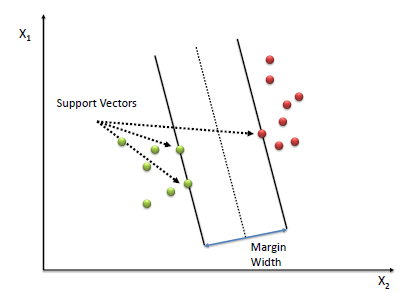


First, we need to make the straight line "unbiased" to any class. So the distance from + support vector to the line should equal to the - support vector;
Second, if the margin value is small, it means it will be too sensitive to these support vectors. If you change dataset, the support vector will vary and your classifier will not be robust. As the figure below, all the lines are biased or "support vector sensitive".

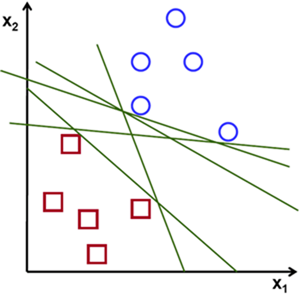

 
The goal of the Linear SVC is to MAXIMIZE the width of the margin.

## **Soft margin SVC**

When you use the python Linear SVC function, there are 2 parameters you can control. One is the alpha, which is the same alpha we talked about it before. The larger alpha is, the wider your margin is.
The other parameter is C, it comes from "Soft margin SVC".
Since most datasets are not so ideal to separate perfectly by a straight line, we can allow a few samples to go across it, which we call soft margin. Like this,

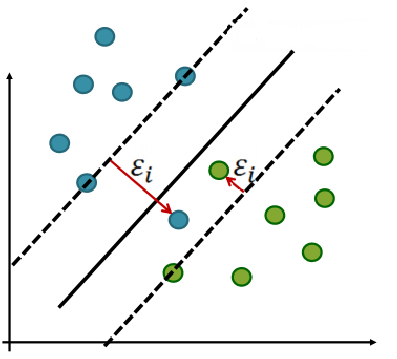

 
Then we need to rewrite our model into,

$$ Y_{i} (\vec{\omega}\cdot \vec{X_{i}} + b ) = 1 - C_{i}$$


The larger the C is, the more mislabeled sample you allowed. It will increase the robustness of your model, but it will decrease your precision.

## **Kernels**

Another import part of SVC is the kernel. It allows user to project the P-dimension dataset into other dimensions for a better seperation.
A kernel is a tranform function. It takes in P-dimension dataset and spits out the transformation new dataset.
One simple example is, a 2D linear non-seperatable dataset, after transforming it into 3D, it becomes seperable.

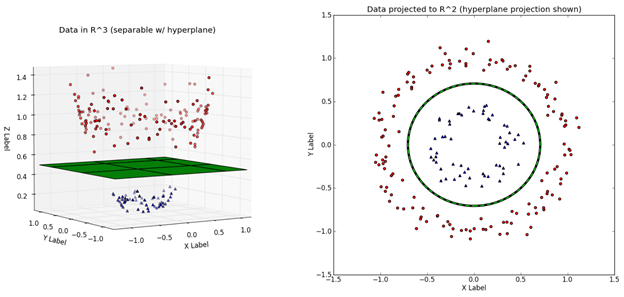

## **Normalization**

Another thing to keep in mind is, before you feed the SVC model, please make sure you've scaled your data or normalized it. Cause it will affect the result a lot.

# Initial run (Full dataset with LinearSVC)

We begin by initially running the full dataset on LinearSVC

## Using default Loss

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [8]:
# Start timer
print('LinearSVC')
start = timeit.default_timer()

svc_linear = LinearSVC(dual=False, max_iter=5000).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvcdef = 100*accuracy_score(testY,y_pred)
precision_linsvcdef = 100*precision_score(testY,y_pred)
f1_linsvcdef = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvcdef))
print("Precision: {:.04f}%".format(precision_linsvcdef))
print("F1 score: {:.04f}%".format(f1_linsvcdef))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

LinearSVC
Training time:  173.08853140000065
Test time:  0.058559999997669365
Out of 400000 datapoints
Accuracy: 89.2537%
Precision: 88.8915%
F1 score: 89.3036%
Confusion Matrix: 
 [[177576  22424]
 [ 20561 179439]]


In [17]:
y_perf_linsvcdef = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvcdef))
y_val_linsvcdef = np.array([accuracy_linsvcdef,precision_linsvcdef,f1_linsvcdef])

<BarContainer object of 3 artists>

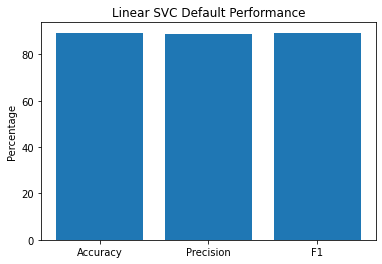

In [18]:
plt.xticks(ypos,y_perf_linsvcdef)
plt.ylabel("Percentage")
plt.title("Linear SVC Default Performance")
plt.bar(ypos,y_val_linsvcdef)

## Using loss="hinge"

In [10]:
# Start timer
print('LinearSVC')
start = timeit.default_timer()

svc_linear = LinearSVC(loss="hinge", max_iter=10000).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvchinge = 100*accuracy_score(testY,y_pred)
precision_linsvchinge = 100*precision_score(testY,y_pred)
f1_linsvchinge = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvchinge))
print("Precision: {:.04f}%".format(precision_linsvchinge))
print("F1 score: {:.04f}%".format(f1_linsvchinge))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

LinearSVC
Training time:  168.28187290000278
Test time:  0.0586208999993687
Out of 400000 datapoints
Accuracy: 89.3100%
Precision: 89.0682%
F1 score: 89.3430%
Confusion Matrix: 
 [[178001  21999]
 [ 20761 179239]]


In [19]:
y_perf_linsvchinge = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvchinge))
y_val_linsvchinge = np.array([accuracy_linsvchinge,precision_linsvchinge,f1_linsvchinge])

<BarContainer object of 3 artists>

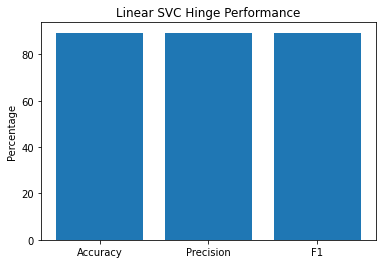

In [20]:
plt.xticks(ypos,y_perf_linsvchinge)
plt.ylabel("Percentage")
plt.title("Linear SVC Hinge Performance")
plt.bar(ypos,y_val_linsvchinge)

As we can see it matters very little what loss function we use. We get a fairly decent accuracy of around 89% regardless and the difference is small enough that it could be an artefact of the data.

# Bagging LinearSVC
## With 620K samples

Here we are using bagging (drawing repeatedly with replacement, testing on the drawn dataset, and potentially repeating the process then classifying according to majority vote.

The reason that 620K samples has been picked is that this is the "sweet spot" we found through testing on the dataset. In general, as is clear, we can see that accuracy does go up slightly as we increase the number of iterations.

### Using default loss

In [11]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator (bagging taken in from SVC)
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(dual=False, max_iter=1000) ,n_jobs=3,
                verbose=2, n_estimators=60, random_state=0,
                max_samples=(620*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvcdefbag = 100*accuracy_score(testY,y_pred)
precision_linsvcdefbag = 100*precision_score(testY,y_pred)
f1_linsvcdefbag = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvcdefbag))
print("Precision: {:.04f}%".format(precision_linsvcdefbag))
print("F1 score: {:.04f}%".format(f1_linsvcdefbag))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging with linearSVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 13.8min finished


Training time:  828.8706318000004


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   12.8s finished


Test time:  12.998586000001524
Out of 400000 datapoints
Accuracy: 89.3462%
Precision: 89.0140%
F1 score: 89.3914%
Confusion Matrix: 
 [[177841  22159]
 [ 20456 179544]]


In [21]:
y_perf_linsvcdefbag = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvcdefbag))
y_val_linsvcdefbag = np.array([accuracy_linsvcdefbag,precision_linsvcdefbag,f1_linsvcdefbag])

<BarContainer object of 3 artists>

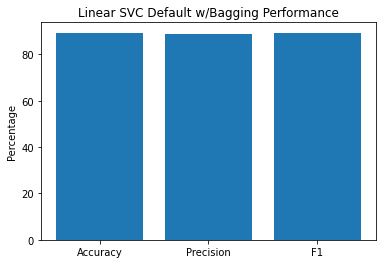

In [22]:
plt.xticks(ypos,y_perf_linsvcdefbag)
plt.ylabel("Percentage")
plt.title("Linear SVC Default w/Bagging Performance")
plt.bar(ypos,y_val_linsvcdefbag)

### Using loss="hinge"

In [12]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(loss="hinge", max_iter=10000) ,n_jobs=3,
                verbose=2, n_estimators=60, random_state=0,
                max_samples=(620*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvchingebag = 100*accuracy_score(testY,y_pred)
precision_linsvchingebag = 100*precision_score(testY,y_pred)
f1_linsvchingebag = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvchingebag))
print("Precision: {:.04f}%".format(precision_linsvchingebag))
print("F1 score: {:.04f}%".format(f1_linsvchingebag))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging with linearSVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 10.3min finished


Training time:  619.8532635999982


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   14.4s finished


Test time:  14.664081599999918
Out of 400000 datapoints
Accuracy: 89.2530%
Precision: 89.0197%
F1 score: 89.2850%
Confusion Matrix: 
 [[177908  22092]
 [ 20896 179104]]


In [23]:
y_perf_linsvchingebag = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvchingebag))
y_val_linsvchingebag = np.array([accuracy_linsvchingebag,precision_linsvchingebag,f1_linsvchingebag])

<BarContainer object of 3 artists>

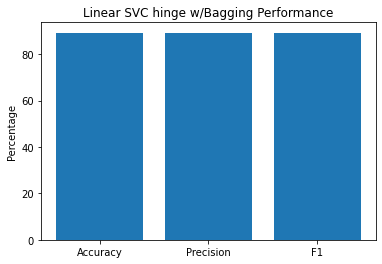

In [24]:
plt.xticks(ypos,y_perf_linsvchingebag)
plt.ylabel("Percentage")
plt.title("Linear SVC hinge w/Bagging Performance")
plt.bar(ypos,y_val_linsvchingebag)

## With 3.6M samples

In [13]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(dual=False, max_iter=1000) ,n_jobs=3,
                verbose=2, n_estimators=60, random_state=0,
                max_samples=(3600*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvc3_6m = 100*accuracy_score(testY,y_pred)
precision_linsvc3_6m = 100*precision_score(testY,y_pred)
f1_linsvc3_6m = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvc3_6m))
print("Precision: {:.04f}%".format(precision_linsvc3_6m))
print("F1 score: {:.04f}%".format(f1_linsvc3_6m))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging with linearSVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 66.6min finished


Training time:  3997.068454100001


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   13.7s finished


Test time:  13.985091999995348
Out of 400000 datapoints
Accuracy: 89.2482%
Precision: 88.9377%
F1 score: 89.2910%
Confusion Matrix: 
 [[177699  22301]
 [ 20706 179294]]


In [25]:
y_perf_linsvc3_6m = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvc3_6m))
y_val_linsvc3_6m = np.array([accuracy_linsvc3_6m,precision_linsvc3_6m,f1_linsvc3_6m])

<BarContainer object of 3 artists>

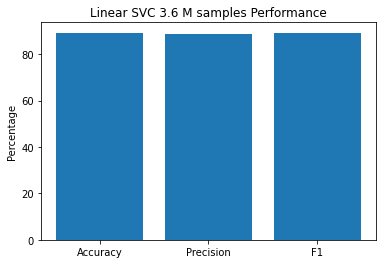

In [26]:
plt.xticks(ypos,y_perf_linsvc3_6m)
plt.ylabel("Percentage")
plt.title("Linear SVC 3.6 M samples Performance")
plt.bar(ypos,y_val_linsvc3_6m)

We can see that using the entire dataset to draw from actually creates a worse estimator than using 620K. Moreover we see that even a much smaller dataset gives a fairly good result.

## With 100K samples

In [14]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(dual=False, max_iter=1000) ,n_jobs=3,
                verbose=0, n_estimators=12, random_state=0,
                max_samples=(100*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvc100k = 100*accuracy_score(testY,y_pred)
precision_linsvc100k = 100*precision_score(testY,y_pred)
f1_linsvc100k = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvc100k))
print("Precision: {:.04f}%".format(precision_linsvc100k))
print("F1 score: {:.04f}%".format(f1_linsvc100k))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging with linearSVC
Training time:  63.23436450000008
Test time:  3.11320490000071
Out of 400000 datapoints
Accuracy: 88.8705%
Precision: 89.1173%
F1 score: 88.8353%
Confusion Matrix: 
 [[178372  21628]
 [ 22890 177110]]


In [27]:
y_perf_linsvc100k = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvc100k))
y_val_linsvc100k = np.array([accuracy_linsvc100k,precision_linsvc100k,f1_linsvc100k])

<BarContainer object of 3 artists>

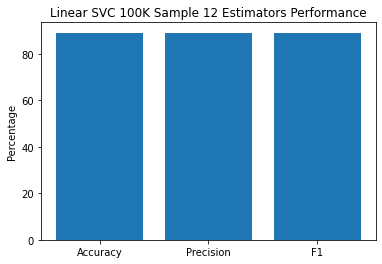

In [28]:
plt.xticks(ypos,y_perf_linsvc100k)
plt.ylabel("Percentage")
plt.title("Linear SVC 100K Sample 12 Estimators Performance")
plt.bar(ypos,y_val_linsvc100k)

In [15]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(dual=False, max_iter=1000) ,n_jobs=3,
                verbose=0, n_estimators=60, random_state=0,
                max_samples=(100*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
#Performance Measures
accuracy_linsvc100k2 = 100*accuracy_score(testY,y_pred)
precision_linsvc100k2 = 100*precision_score(testY,y_pred)
f1_linsvc100k2 = 100*f1_score(testY,y_pred)
# Printing results
print("Out of", len(testY), 'datapoints')
print("Accuracy: {:.04f}%".format(accuracy_linsvc100k2))
print("Precision: {:.04f}%".format(precision_linsvc100k2))
print("F1 score: {:.04f}%".format(f1_linsvc100k2))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print("Confusion Matrix: \n",m)

Bagging with linearSVC
Training time:  188.8942637
Test time:  14.28943309999886
Out of 400000 datapoints
Accuracy: 89.0870%
Precision: 88.8141%
F1 score: 89.1252%
Confusion Matrix: 
 [[177471  22529]
 [ 21123 178877]]


In [29]:
y_perf_linsvc100k2 = np.array(["Accuracy","Precision","F1"])
ypos = np.arange(len(y_perf_linsvc100k2))
y_val_linsvc100k2 = np.array([accuracy_linsvc100k2,precision_linsvc100k2,f1_linsvc100k2])

<BarContainer object of 3 artists>

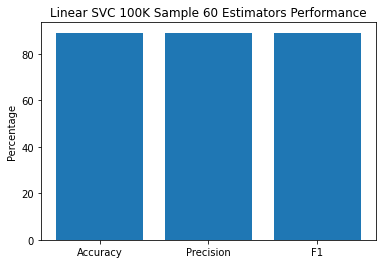

In [30]:
plt.xticks(ypos,y_perf_linsvc100k2)
plt.ylabel("Percentage")
plt.title("Linear SVC 100K Sample 60 Estimators Performance")
plt.bar(ypos,y_val_linsvc100k2)

In [44]:
y_accu_linsvc = np.array(["Full Def","Full Hinge","DefBag","HingeBag","3.6M Sample","100K E12","100K E60"])
y_f1_linsvc = np.array(["Full Def","Full Hinge","DefBag","HingeBag","3.6M Sample","100K E12","100K E60"])
ypos = np.arange(len(y_accu_linsvc))
y_val_acculinsvc = np.array([accuracy_linsvcdef,accuracy_linsvchinge,accuracy_linsvcdefbag,accuracy_linsvchingebag,accuracy_linsvc3_6m,accuracy_linsvc100k,accuracy_linsvc100k2])
y_val_f1linsvc = np.array([f1_linsvcdef,f1_linsvchinge,f1_linsvcdefbag,f1_linsvchingebag,f1_linsvc3_6m,f1_linsvc100k,f1_linsvc100k2])

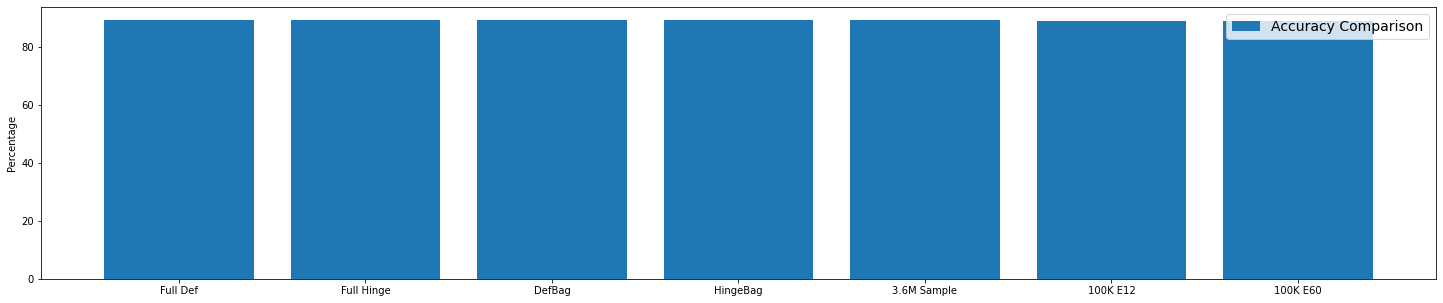

In [54]:
f, ax = plt.subplots(figsize=(25,5)) # set the size that you'd like (width, height)
plt.bar(y_accu_linsvc, y_val_acculinsvc, label = 'Accuracy Comparison')
plt.ylabel("Percentage")
ax.legend(fontsize = 14)

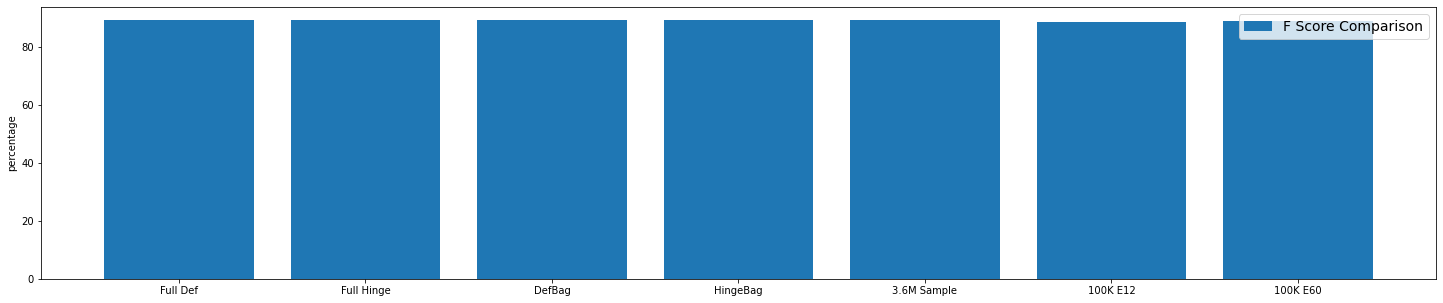

In [55]:
f, ax = plt.subplots(figsize=(25,5)) # set the size that you'd like (width, height)
plt.bar(y_f1_linsvc, y_val_f1linsvc, label = 'F Score Comparison')
plt.ylabel("percentage")
ax.legend(fontsize = 14)

# Best Bagging LinearSVC

This is the bagging LinearSVC model that gives the best result, though as we can see this is not by a long shot.

In [16]:
# Start timer
print('Bagging with linearSVC')
start = timeit.default_timer()

# Estimator
svc_linear = BaggingClassifier(base_estimator=
                LinearSVC(dual=False, max_iter=1000) ,n_jobs=3,
                verbose=2, n_estimators=600, random_state=0,
                max_samples=(620*(10**3)),
                ).fit(trainX, trainY)
# stop timer
stop = timeit.default_timer()
print('Training time: ', stop - start)
# Start timer
start = timeit.default_timer()
# Getting prediction.
y_pred = svc_linear.predict(testX)
# stop timer
stop = timeit.default_timer()
print('Test time: ', stop - start)
# Printing results
print("Out of", len(testY), 'datapoints, our accuracy was {:.03f}%.'
      .format(100*(1-(y_pred != testY).sum()/len(testY))))
m = confusion_matrix(y_true=testY, y_pred=y_pred)
print(m)

Bagging with linearSVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed: 166.1min finished


Training time:  9963.954086529993


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  2.0min finished


Test time:  123.20168788499723
Out of 400000 datapoints, our accuracy was 89.349%.
[[177698  22302]
 [ 20302 179698]]


## References:
https://www.kaggle.com/xingewang/the-math-behind-linear-svc-classifier